In [36]:
# Imports
import csv
import time
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn import linear_model

In [37]:
path = 'datasets/airports.csv'
reader = csv.reader(open(path, 'rt'), delimiter=',')
airports = defaultdict(str)
header = next(reader)
for line in reader:
    d = dict(zip(header, line))
    if d['IATA_CODE'].isdigit(): continue
    airports[d['IATA_CODE']] = d['STATE']

In [38]:
# Read dataset
path = 'datasets/flights.csv'
reader = csv.reader(open(path, 'rt'), delimiter=',')
dataset = []
header = next(reader)
to_remove_fields = ['YEAR', 'TAXI_OUT', 'TAIL_NUMBER', 'TAXI_OUT', 'WHEELS_OFF', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 
                    'DIVERTED','AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY']
for line in reader:
    d = dict(zip(header, line))
    if d['ORIGIN_AIRPORT'].isdigit() or d['DESTINATION_AIRPORT'].isdigit(): continue
    if airports[d['ORIGIN_AIRPORT']] != 'CA' or airports[d['DESTINATION_AIRPORT']] != 'CA': continue
    for field in to_remove_fields:
        d.pop(field, None)
    dataset.append(d)

In [39]:
# 5819079, 5332914, 208859
len(dataset), dataset[0]

(208859,
 {'MONTH': '1',
  'DAY': '1',
  'DAY_OF_WEEK': '4',
  'AIRLINE': 'OO',
  'FLIGHT_NUMBER': '5467',
  'ORIGIN_AIRPORT': 'ONT',
  'DESTINATION_AIRPORT': 'SFO',
  'SCHEDULED_DEPARTURE': '0500',
  'DEPARTURE_TIME': '0513',
  'DEPARTURE_DELAY': '13',
  'SCHEDULED_TIME': '89',
  'ELAPSED_TIME': '85',
  'DISTANCE': '363',
  'SCHEDULED_ARRIVAL': '0629',
  'ARRIVAL_TIME': '0638',
  'ARRIVAL_DELAY': '9',
  'CANCELLED': '0',
  'CANCELLATION_REASON': '',
  'WEATHER_DELAY': ''})

# Exploration

## Airport Locations

In [40]:
airport_count = defaultdict(int)
for d in dataset:
    airport_count[d['ORIGIN_AIRPORT']] += 1

In [41]:
airport_count

defaultdict(int,
            {'ONT': 7654,
             'RDD': 727,
             'FAT': 3080,
             'SMX': 664,
             'SFO': 41778,
             'OAK': 19172,
             'SMF': 16904,
             'CLD': 641,
             'ACV': 1320,
             'MRY': 2346,
             'PSP': 2874,
             'LAX': 44236,
             'SBP': 2416,
             'SAN': 21123,
             'BFL': 660,
             'SNA': 11635,
             'LGB': 2660,
             'BUR': 9570,
             'SBA': 3557,
             'SJC': 15506,
             'MMH': 146,
             'CEC': 190})

In [42]:
# Convert to time
rowsToDrop = set()
for i in range(len(dataset)):
    d = dataset[i]
    try:
        d['SCHEDULED_DEPARTURE'] = time.strptime(d['SCHEDULED_DEPARTURE'], "%H%M")
        d['DEPARTURE_TIME'] = time.strptime(d['DEPARTURE_TIME'], "%H%M")
        d['SCHEDULED_ARRIVAL'] = time.strptime(d['SCHEDULED_ARRIVAL'], "%H%M")
        d['ARRIVAL_TIME'] = time.strptime(d['ARRIVAL_TIME'], "%H%M")
    except:
        rowsToDrop.add(i)
dataset = [dataset[i] for i in range(len(dataset)) if i not in rowsToDrop]

In [43]:
dataset[0]

{'MONTH': '1',
 'DAY': '1',
 'DAY_OF_WEEK': '4',
 'AIRLINE': 'OO',
 'FLIGHT_NUMBER': '5467',
 'ORIGIN_AIRPORT': 'ONT',
 'DESTINATION_AIRPORT': 'SFO',
 'SCHEDULED_DEPARTURE': time.struct_time(tm_year=1900, tm_mon=1, tm_mday=1, tm_hour=5, tm_min=0, tm_sec=0, tm_wday=0, tm_yday=1, tm_isdst=-1),
 'DEPARTURE_TIME': time.struct_time(tm_year=1900, tm_mon=1, tm_mday=1, tm_hour=5, tm_min=13, tm_sec=0, tm_wday=0, tm_yday=1, tm_isdst=-1),
 'DEPARTURE_DELAY': '13',
 'SCHEDULED_TIME': '89',
 'ELAPSED_TIME': '85',
 'DISTANCE': '363',
 'SCHEDULED_ARRIVAL': time.struct_time(tm_year=1900, tm_mon=1, tm_mday=1, tm_hour=6, tm_min=29, tm_sec=0, tm_wday=0, tm_yday=1, tm_isdst=-1),
 'ARRIVAL_TIME': time.struct_time(tm_year=1900, tm_mon=1, tm_mday=1, tm_hour=6, tm_min=38, tm_sec=0, tm_wday=0, tm_yday=1, tm_isdst=-1),
 'ARRIVAL_DELAY': '9',
 'CANCELLED': '0',
 'CANCELLATION_REASON': '',
 'WEATHER_DELAY': ''}

## Basic Statistics

### Num of Flights Per Airline Company

In [44]:
num_flights_per_airline = defaultdict(int)
for d in dataset:
    num_flights_per_airline[d['AIRLINE']] += 1

In [45]:
num_flights_per_airline

defaultdict(int,
            {'OO': 74361,
             'UA': 12659,
             'B6': 5272,
             'VX': 9921,
             'AA': 3868,
             'AS': 1247,
             'WN': 93123,
             'DL': 3606,
             'NK': 196})

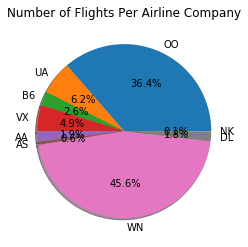

In [46]:
x_vals = []
y_vals = []
total_flights = sum(num_flights_per_airline.values())
for d in num_flights_per_airline:
    x_vals.append(d)
    y_vals.append(num_flights_per_airline[d]/total_flights)
plt.pie(y_vals, labels=x_vals, shadow=True, autopct='%1.1f%%')
# plt.axis('equal')
plt.title('Number of Flights Per Airline Company')
plt.show()

### Delays Distribution Per Airline

In [47]:
# Remove cancelled flights and get the mean delay time for each airline
delays_per_airline = defaultdict(list)
for d in dataset:
    if d['DEPARTURE_DELAY']:
        delays_per_airline[d['AIRLINE']].append(int(d['DEPARTURE_DELAY']))

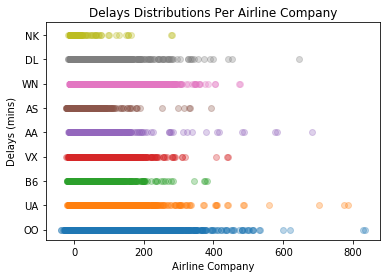

In [48]:
for d in delays_per_airline:
    y = delays_per_airline[d]
    plt.scatter(y, [d] * len(y), alpha=0.3)
plt.xlabel('Airline Company')
plt.ylabel('Delays (mins)')
plt.title('Delays Distributions Per Airline Company')
plt.show()
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)

### Delays Max, Min, Mean Per Airline

In [85]:
x_vals = []
y_min_delay = []
y_max_delay = []
y_mean_delay = []
for d in delays_per_airline:
    x_vals.append(d)
    y_min_delay.append(min(delays_per_airline[d]))
    y_max_delay.append(max(delays_per_airline[d]))
    y_mean_delay.append(sum(delays_per_airline[d]) / len(delays_per_airline[d]))

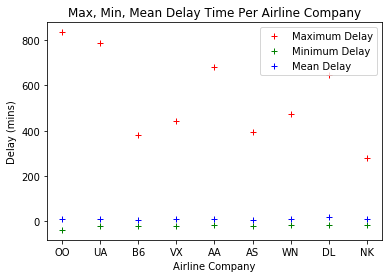

In [86]:
plt.plot(x_vals, y_max_delay, 'r+', label='Maximum Delay')
plt.plot(x_vals, y_min_delay, 'g+', label='Minimum Delay')
plt.plot(x_vals, y_mean_delay, 'b+', label='Mean Delay')
plt.xlabel('Airline Company')
plt.ylabel('Delay (mins)')
plt.title('Max, Min, Mean Delay Time Per Airline Company')
plt.legend()
plt.show()

### Boxplot

In [51]:
x_vals = []
y_vals = []
for d in delays_per_airline:
    x_vals.append(d)
    y_vals.append(list(delays_per_airline[d]))

In [52]:
len(x_vals)

9

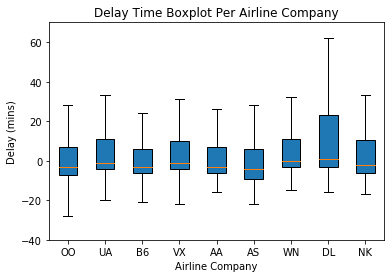

In [53]:
ind = np.arange(1, 10, 1)
plt.ylim(-40, 70)
plt.boxplot(y_vals, patch_artist=True, showfliers=False, labels=x_vals)
plt.xlabel('Airline Company')
plt.ylabel('Delay (mins)')
plt.title('Delay Time Boxplot Per Airline Company')
plt.xticks(ind, x_vals)
plt.show()

### Mean Delays Per Airline Company

In [54]:
mean_delay_per_airline = {}
for d in delays_per_airline:
    mean_delay_per_airline[d] = sum(delays_per_airline[d])/len(delays_per_airline[d])

In [55]:
mean_delay_per_airline

{'OO': 9.155121636341631,
 'UA': 12.216446796745398,
 'B6': 7.69252655538695,
 'VX': 10.629674427981051,
 'AA': 8.966907962771458,
 'AS': 7.115477145148356,
 'WN': 10.337048849371262,
 'DL': 19.466444814198557,
 'NK': 11.933673469387756}

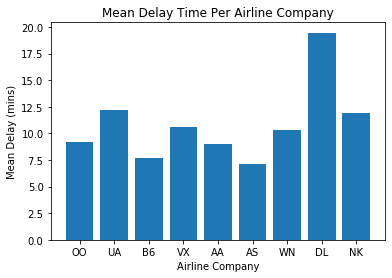

In [56]:
x_vals = []
y_vals = []
for d in mean_delay_per_airline:
    x_vals.append(d)
    y_vals.append(mean_delay_per_airline[d])
plt.bar(x_vals, y_vals)
plt.xlabel('Airline Company')
plt.ylabel('Mean Delay (mins)')
plt.title('Mean Delay Time Per Airline Company')
plt.show()

### Delays Count Categorized

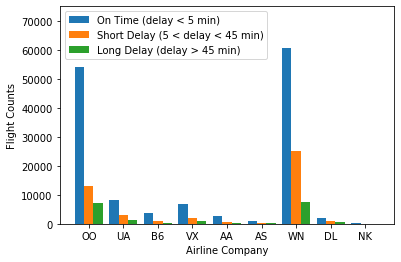

In [57]:
index = 1
width = 0.27
x_vals = []
y_ontime = []
y_short_delay = []
y_long_delay = []
for d in delays_per_airline:
    x_vals.append(d)
    y_ontime.append(0)
    y_short_delay.append(0)
    y_long_delay.append(0)
    for y in delays_per_airline[d]:
        if y < 5: y_ontime[index-1] += 1
        elif y < 45: y_short_delay[index-1] += 1
        else: y_long_delay[index-1] += 1
    index += 1
ind = np.arange(1, 10, 1)
plt.bar(ind-width, y_ontime, width, color='tab:blue', label='On Time (delay < 5 min)')
plt.bar(ind, y_short_delay, width, color='tab:orange', label='Short Delay (5 < delay < 45 min)')
plt.bar(ind+width, y_long_delay, width, color='tab:green', label='Long Delay (delay > 45 min)')
plt.xticks(ind, x_vals)
plt.ylim(0, 7.5e4)
plt.legend(loc='upper left')
plt.xlabel('Airline Company')
plt.ylabel('Flight Counts')
plt.show()

### Delays Per Airport

In [58]:
flights_per_airport = defaultdict(int)
for d in dataset:
    flights_per_airport[d['ORIGIN_AIRPORT']] += 1

In [59]:
### Only for delays > 5 mins
delays_per_airport = defaultdict(list)
for d in dataset:
    if d['DEPARTURE_DELAY'] and int(d['DEPARTURE_DELAY']) > 5:
        delays_per_airport[d['ORIGIN_AIRPORT']].append(d['DEPARTURE_DELAY'])

In [60]:
delays_per_airport

defaultdict(list,
            {'ONT': ['13',
              '18',
              '29',
              '9',
              '15',
              '45',
              '16',
              '49',
              '35',
              '48',
              '28',
              '11',
              '47',
              '21',
              '9',
              '19',
              '15',
              '19',
              '35',
              '103',
              '74',
              '42',
              '20',
              '50',
              '21',
              '18',
              '6',
              '12',
              '32',
              '19',
              '38',
              '64',
              '46',
              '27',
              '64',
              '73',
              '27',
              '30',
              '11',
              '12',
              '31',
              '7',
              '49',
              '246',
              '100',
              '34',
              '41',
              '24',
              '6

In [61]:
percentage_count_delayed_flights_per_airport = defaultdict(float)
for d in delays_per_airport:
    if flights_per_airport[d] == 0: continue
    percentage_count_delayed_flights_per_airport[d] = len(delays_per_airport[d])/flights_per_airport[d]

In [62]:
percentage_count_delayed_flights_per_airport

defaultdict(float,
            {'ONT': 0.30753968253968256,
             'CLD': 0.18630573248407642,
             'PSP': 0.27631115804294265,
             'SFO': 0.2810124714043244,
             'SNA': 0.3186966370447813,
             'LAX': 0.33290110449903904,
             'SMF': 0.2973037891070678,
             'OAK': 0.32576405214789483,
             'SAN': 0.3138305575669805,
             'SJC': 0.31564062088923966,
             'SBP': 0.24438797119864464,
             'SBA': 0.2517341040462428,
             'BUR': 0.23999141354513256,
             'SMX': 0.19631901840490798,
             'FAT': 0.29224194608809995,
             'ACV': 0.2702915681639086,
             'LGB': 0.2791050436101631,
             'RDD': 0.21388101983002833,
             'MMH': 0.31297709923664124,
             'MRY': 0.21508756174225416,
             'CEC': 0.3218390804597701,
             'BFL': 0.2616822429906542})

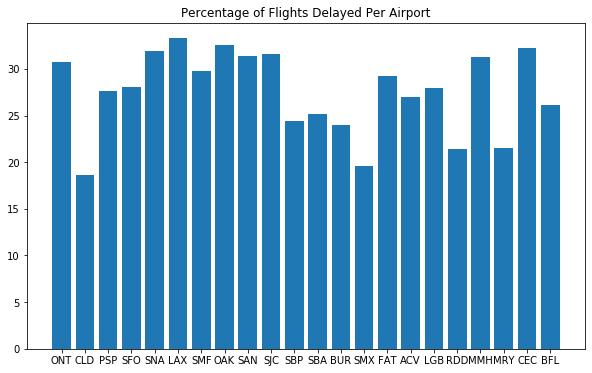

In [63]:
x_vals = []
y_vals = []
for d in percentage_count_delayed_flights_per_airport:
    if d.isdigit(): continue
    x_vals.append(d)
    y_vals.append(percentage_count_delayed_flights_per_airport[d]*100)
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x_vals, y_vals)
plt.title('Percentage of Flights Delayed Per Airport')
plt.show()

In [64]:
len(x_vals)

22

### Mean delay vs Day of week

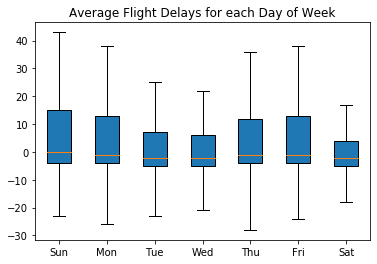

In [84]:
delays = defaultdict(list)
for d in dataset:
    temp = {'1': 'Mon', '2': 'Tue', '3': 'Wed', '4': 'Thu', '5': 'Fri', '6': 'Sat', '7': 'Sun'}
    delays[temp[d['DAY_OF_WEEK']]].append(0 if d['DEPARTURE_DELAY'] == '' else int(d['DEPARTURE_DELAY']))
x_vals = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
y_vals = [delays[k] for k in x_vals]
plt.boxplot(y_vals, patch_artist=True, showfliers=False, labels=x_vals)
plt.title('Average Flight Delays for each Day of Week')
plt.show()

### Mean delay vs Time of day

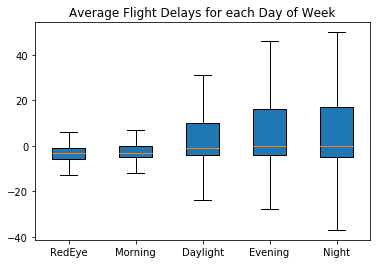

In [82]:
delays = defaultdict(list)
for d in dataset:
    def getTimeSlot(t):
        if t.tm_hour < 6: return 'RedEye'
        if t.tm_hour < 9: return 'Morning'
        if t.tm_hour < 15: return 'Daylight'
        if t.tm_hour < 19: return 'Evening'
        else: return 'Night'
    delays[getTimeSlot(d['SCHEDULED_DEPARTURE'])].append(0 if d['DEPARTURE_DELAY'] == '' else int(d['DEPARTURE_DELAY']))
x_vals = ['RedEye', 'Morning', 'Daylight', 'Evening', 'Night']
y_vals = [delays[k] for k in x_vals]
plt.boxplot(y_vals, patch_artist=True, showfliers=False, labels=x_vals)
plt.title('Average Flight Delays for each Time slot in a day')
plt.show()

## Prediction Task

#### Data Setup


In [5]:
delays_dataset = []
for d in dataset:
    if d['DEPARTURE_DELAY']: 
        delays_dataset.append(d)

In [6]:
# Add a new feature prev flight (same airline and same airport)
prev_flight_delay = {}
for i in range(len(delays_dataset)):
    d = delays_dataset[i]
    tup = (d['AIRLINE'], d['ORIGIN_AIRPORT'])
    if tup not in prev_flight_delay:
        prev_flight_delay[tup] = 0
    delays_dataset[i]['PREV_FLIGHT_DELAY'] = prev_flight_delay[tup]
    prev_flight_delay[tup] = int(d['DEPARTURE_DELAY'])
del prev_flight_delay

In [7]:
# Function to split data 90 - 10
def split_data(data):
    N = len(data)
    trainset = []
    testset = []
    for i in range(len(data)):
        if i % 10 == 0:
            testset.append(data[i])
        else:
            trainset.append(data[i])
    return trainset, testset

In [8]:
train, test = split_data(delays_dataset)
train, valid = split_data(train)
N = len(delays_dataset)
Ntrain = len(train)
Nvalid = len(valid)
Ntest = len(test)
N, Ntrain, Nvalid, Ntest, Ntrain+Nvalid+Ntest

(204537, 165674, 18409, 20454, 204537)

In [9]:
airline_set = set()
airport_set = set()
for d in delays_dataset:
    airline_set.add(d['AIRLINE'])
    airport_set.add(d['ORIGIN_AIRPORT'])
airline_list = list(airline_set)
airline_list.sort()
airport_list = list(airport_set)
airport_list.sort()
airline_encoding = {}
airport_encoding = {}
for i in range(len(airline_list)):
    airline_encoding[airline_list[i]] = i
for i in range(len(airport_list)):
    airport_encoding[airport_list[i]] = i
del airline_set, airline_list
del airport_set, airport_list

In [11]:
# del dataset

In [12]:
airline_encoding, airport_encoding

({'AA': 0,
  'AS': 1,
  'B6': 2,
  'DL': 3,
  'NK': 4,
  'OO': 5,
  'UA': 6,
  'VX': 7,
  'WN': 8},
 {'ACV': 0,
  'BFL': 1,
  'BUR': 2,
  'CEC': 3,
  'CLD': 4,
  'FAT': 5,
  'LAX': 6,
  'LGB': 7,
  'MMH': 8,
  'MRY': 9,
  'OAK': 10,
  'ONT': 11,
  'PSP': 12,
  'RDD': 13,
  'SAN': 14,
  'SBA': 15,
  'SBP': 16,
  'SFO': 17,
  'SJC': 18,
  'SMF': 19,
  'SMX': 20,
  'SNA': 21})

In [10]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences)/len(differences)

In [11]:
def feature_baseline_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    feat = [1] + airline_feat + airport_feat
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    return feat

In [12]:
def feature_baseline(datum):
    feat = [1, datum['AIRLINE'], datum['ORIGIN_AIRPORT']]
    return feat

In [13]:
thres = 60

# Training data features
Xtrain = [feature_baseline_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
ctrain = [1 if int(d['DEPARTURE_DELAY']) > thres else 0 for d in train]
print("training set")

# Valid data features
Xvalid = [feature_baseline_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
cvalid = [1 if int(d['DEPARTURE_DELAY']) > thres else 0 for d in valid]
print("valid set")

# Test data features
Xtest = [feature_baseline_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
ctest = [1 if int(d['DEPARTURE_DELAY']) > thres else 0 for d in test]
print("test set")


training set
valid set
test set


In [44]:
Xtest[0], ytest[0], Xtrain[0], ytrain[0], train[0]

([1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 13,
 [1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0],
 5,
 {'MONTH': '1',
  'DAY': '1',
  'DAY_OF_WEEK': '4',
  'AIRLINE': 'UA',
  'FLIGHT_NUMBER': '1224',
  'ORIGIN_AIRPORT': 'SFO',
  'DESTINATION_AIRPORT': 'LAX',
  'SCHEDULED_DEPARTURE': '0600',
  'DEPARTURE_TIME': '0605',
  'DEPARTURE_DELAY': '5',
  'SCHEDULED_TIME': '88',
  'ELAPSED_TIME': '72',
  'DISTANCE': '337',
  'SCHEDULED_ARRIVAL': '0728',
  'ARRIVAL_TIME': '0717',
  'ARRIVAL_DELAY': '-11',
  'CANCELLED': '0',
  'CANCELLATION_REASON': '',
  'WEATHER_DELAY': '',
  'PREV_FLIGHT_DELAY': 0})

In [80]:
theta, residual, rank, s = np.linalg.lstsq(Xtrain, ytrain, rcond=None)
print("Trained")
predictions_train = np.matmul(Xtrain, theta)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = np.matmul(Xtest, theta)
test_accuracy = MSE(predictions_test, ytest)
ytest_normal = [ytest[i] for i in range(len(ytest)) if ctest[i] == 0]
test_accuracy_normal = MSE([predictions_test[i] for i in range(len(ytest)) if ctest[i] == 0], ytest_normal)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))
print("MSE on test set (normal): " + str(test_accuracy_normal))

Trained
MSE on training set: 1051.245050529889
MSE on test set: 1016.0178192842035
MSE on test set (normal): 241.5599452475441


In [81]:
regressor = linear_model.LinearRegression()
regressor.fit(Xtrain, ytrain)
print("Trained")
predictions_train = regressor.predict(Xtrain)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(Xtest)
test_accuracy = MSE(predictions_test, ytest)
test_accuracy_normal = MSE([predictions_test[i] for i in range(len(ytest)) if ctest[i] == 0], ytest_normal)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))
print("MSE on test set (normal): " + str(test_accuracy_normal))

Trained
MSE on training set: 1051.2543948138168
MSE on test set: 1015.9799105859728
MSE on test set (normal): 241.63408708766568


In [87]:
def feature(datum):
    feat = [1, datum['AIRLINE'], datum['ORIGIN_AIRPORT'], datum['PREV_FLIGHT_DELAY']]
    return feat

In [88]:
def feature_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    month_feat = [0]*12
    feat = [1] + airline_feat + airport_feat + month_feat + [int(datum['PREV_FLIGHT_DELAY'])]
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    ind_month = int(datum['MONTH']) + len(airport_encoding) + len(airline_encoding) + 1 - 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    feat[ind_month] = 1
    return feat

In [89]:
# Training data features
Xtrain = [feature_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
print("training set")

# Valid data features
Xvalid = [feature_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
print("valid set")

# Test data features
Xtest = [feature_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
print("test set")


training set
valid set
test set


In [109]:
Xtrain[0], ytrain[0], train[0]

([1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 5,
 {'MONTH': '1',
  'DAY': '1',
  'DAY_OF_WEEK': '4',
  'AIRLINE': 'UA',
  'FLIGHT_NUMBER': '1224',
  'ORIGIN_AIRPORT': 'SFO',
  'DESTINATION_AIRPORT': 'LAX',
  'SCHEDULED_DEPARTURE': '0600',
  'DEPARTURE_TIME': '0605',
  'DEPARTURE_DELAY': '5',
  'SCHEDULED_TIME': '88',
  'ELAPSED_TIME': '72',
  'DISTANCE': '337',
  'SCHEDULED_ARRIVAL': '0728',
  'ARRIVAL_TIME': '0717',
  'ARRIVAL_DELAY': '-11',
  'CANCELLED': '0',
  'CANCELLATION_REASON': '',
  'WEATHER_DELAY': '',
  'PREV_FLIGHT_DELAY': 0})

In [90]:
regressor = linear_model.LinearRegression()
regressor.fit(Xtrain, ytrain)
predictions_train = regressor.predict(Xtrain)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(Xtest)
test_accuracy = MSE(predictions_test, ytest)
test_accuracy_normal = MSE([predictions_test[i] for i in range(len(ytest)) if ctest[i] == 0], ytest_normal)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))
print("MSE on test set (normal): " + str(test_accuracy_normal))

MSE on training set: 1019.14435921868
MSE on test set: 987.2611475199088
MSE on test set (normal): 243.81358839778858


### Predict Model 3

In [91]:
def feature_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    month_feat = [0]*12
    day_of_week_feat = [0]*7
    airport_dst_feat = [0]*len(airport_encoding)
    feat = [1] + airline_feat + airport_feat + month_feat + day_of_week_feat + airport_dst_feat + [int(datum['PREV_FLIGHT_DELAY'])]
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    ind_month = int(datum['MONTH']) + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_day_of_week = int(datum['DAY_OF_WEEK']) + 12 + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_airport_dst = airport_encoding[datum['DESTINATION_AIRPORT']] + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    feat[ind_month] = 1
    feat[ind_day_of_week] = 1
    feat[ind_airport_dst] = 1
    return feat

# Training data features
Xtrain = [feature_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
print("training set")

# Valid data features
Xvalid = [feature_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
print("valid set")

# Test data features
Xtest = [feature_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
print("test set")


training set
valid set
test set


In [92]:
regressor = linear_model.LinearRegression()
regressor.fit(Xtrain, ytrain)
predictions_train = regressor.predict(Xtrain)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(Xtest)
test_accuracy = MSE(predictions_test, ytest)
test_accuracy = MSE(predictions_test, ytest)
test_accuracy_normal = MSE([predictions_test[i] for i in range(len(ytest)) if ctest[i] == 0], ytest_normal)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))
print("MSE on test set (normal): " + str(test_accuracy_normal))

MSE on training set: 1008.7744158796227
MSE on test set: 977.7327252735631
MSE on test set (normal): 246.0632704106829


### Predict Model 4

In [14]:
import json
with open('datasets/Latent2_3_train_26700.txt', "r") as f:
    obj = json.loads(f.readline())
    airports = obj['airports']
    airlines = obj['airlines']
    airportGamma = obj['airportGamma']
    airlineGamma = obj['airlineGamma']

In [94]:
airportGamma

{'CEC': [1.922032097047643, 1.8768021556144787, 2.4743505665289245],
 'BFL': [-1.9176310510654833, 0.7166447137753071, 2.1532205941627485],
 'RDD': [3.0529263008619223, 2.3455268956049116, 2.0224784083058904],
 'SMF': [2.4526935157931273, 1.8807322602507215, -0.7237075685560702],
 'SMX': [-1.1452257960279422, 0.5369311073941674, 2.344167621783833],
 'CLD': [-0.3905280772542386, -2.718244346728181, 1.1509534377661452],
 'SJC': [-0.37538700235972233, 1.4154737449423027, -0.7995526701282638],
 'LGB': [2.2315331857410925, 0.7435140345337298, 0.5358492483828244],
 'ACV': [-2.503785808961028, -1.6748676348877236, -0.7789330198000569],
 'BUR': [-2.4532164447463494, -1.6455246978237676, -1.5959957945407648],
 'LAX': [1.1955788881342315, -2.5130446515560068, 2.80152358926298],
 'SBP': [-0.6944802921899987, 0.3384408762134049, 1.2984844778100304],
 'FAT': [-1.8978714584312741, 0.9689920961190237, 0.08464105547998363],
 'OAK': [-1.2747725620279975, 2.37356911561439, -0.6343397431620014],
 'PSP': 

In [15]:
def feature_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    month_feat = [0]*12
    day_of_week_feat = [0]*7
    airport_dst_feat = [0]*len(airport_encoding)
    interaction = np.inner(np.add(np.array(airportGamma[datum['ORIGIN_AIRPORT']]), np.array(airportGamma[datum['DESTINATION_AIRPORT']])), np.array(airlineGamma[datum['AIRLINE']]))
    feat = [1] + airline_feat + airport_feat + month_feat + day_of_week_feat + airport_dst_feat + [int(datum['PREV_FLIGHT_DELAY'])] + [interaction]
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    ind_month = int(datum['MONTH']) + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_day_of_week = int(datum['DAY_OF_WEEK']) + 12 + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_airport_dst = airport_encoding[datum['DESTINATION_AIRPORT']] + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    feat[ind_month] = 1
    feat[ind_day_of_week] = 1
    feat[ind_airport_dst] = 1
    return feat

# Training data features
Xtrain = [feature_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
print("training set")

# Valid data features
Xvalid = [feature_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
print("valid set")

# Test data features
Xtest = [feature_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
print("test set")


training set
valid set
test set


In [99]:
regressor = linear_model.LinearRegression()
regressor.fit(Xtrain, ytrain)
predictions_train = regressor.predict(Xtrain)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(Xtest)
test_accuracy = MSE(predictions_test, ytest)
test_accuracy = MSE(predictions_test, ytest)
test_accuracy_normal = MSE([predictions_test[i] for i in range(len(ytest)) if ctest[i] == 0], ytest_normal)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))
print("MSE on test set (normal): " + str(test_accuracy_normal))

MSE on training set: 1008.5163277943428
MSE on test set: 976.8563121466115
MSE on test set (normal): 245.89582376423775


### Predict Model 5

In [100]:
def feature_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    month_feat = [0]*12
    day_of_week_feat = [0]*7
    airport_dst_feat = [0]*len(airport_encoding)
    dep_time = [0]*4
    feat = [1] + airline_feat + airport_feat + month_feat + day_of_week_feat + airport_dst_feat + dep_time + [int(datum['PREV_FLIGHT_DELAY'])] + airportGamma[datum['ORIGIN_AIRPORT']] + airportGamma[datum['DESTINATION_AIRPORT']] + airlineGamma[datum['AIRLINE']]
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    ind_month = int(datum['MONTH']) + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_day_of_week = int(datum['DAY_OF_WEEK']) + 12 + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_airport_dst = airport_encoding[datum['DESTINATION_AIRPORT']] + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    ind_dep_time = 0
    if int(datum['DEPARTURE_TIME']) < 900:
        ind_dep_time = 0
    elif int(datum['DEPARTURE_TIME']) < 1100:
        ind_dep_time = 1
    elif int(datum['DEPARTURE_TIME']) < 2100:
        ind_dep_time = 2
    else:
        ind_dep_time = 3
    ind_dep_time = ind_dep_time + len(airport_encoding) + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    feat[ind_month] = 1
    feat[ind_day_of_week] = 1
    feat[ind_airport_dst] = 1
    feat[ind_dep_time] = 1
    return feat

# Training data features
Xtrain = [feature_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
print("training set")

# Valid data features
Xvalid = [feature_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
print("valid set")

# Test data features
Xtest = [feature_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
print("test set")


training set
valid set
test set


In [101]:
regressor = linear_model.LinearRegression()
regressor.fit(Xtrain, ytrain)
predictions_train = regressor.predict(Xtrain)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(Xtest)
test_accuracy = MSE(predictions_test, ytest)
test_accuracy = MSE(predictions_test, ytest)
test_accuracy_normal = MSE([predictions_test[i] for i in range(len(ytest)) if ctest[i] == 0], ytest_normal)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))
print("MSE on test set (normal): " + str(test_accuracy_normal))

MSE on training set: 968.0160854817607
MSE on test set: 940.1131464615319
MSE on test set (normal): 246.04517472196642


### Predict Average for Each Airline

In [30]:
train_delays_per_airline = defaultdict(list)
for d in train:
    train_delays_per_airline[d['AIRLINE']].append(int(d['DEPARTURE_DELAY']))

In [31]:
average_delays_per_airline = defaultdict(float)
for d in train_delays_per_airline:
    average_delays_per_airline[d] = sum(train_delays_per_airline[d])/len(train_delays_per_airline[d])

In [32]:
average_delays_per_airline

defaultdict(float,
            {'UA': 12.313213066796685,
             'B6': 7.686842720261743,
             'OO': 9.10770836093812,
             'VX': 10.548656047784968,
             'AS': 6.801548886737657,
             'WN': 10.353384454421445,
             'AA': 9.181327405525563,
             'DL': 19.65580589254766,
             'NK': 12.383116883116884})

In [33]:
ypred = []
for x in test:
    ypred.append(average_delays_per_airline[x['AIRLINE']])
test_accuracy = MSE(ypred, ytest)
print("MSE on test set: " + str(test_accuracy))

MSE on test set: 1016.4428926186471


In [67]:
test[0]['AIRLINE']

'OO'

### Predict Model 6 (xgboost)

In [41]:
def feature_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    month_feat = [0]*12
    day_of_week_feat = [0]*7
    airport_dst_feat = [0]*len(airport_encoding)
    dep_time = [0]*4
    feat = [1] + airline_feat + airport_feat + month_feat + day_of_week_feat + airport_dst_feat + dep_time + [int(datum['PREV_FLIGHT_DELAY'])] + airportGamma[datum['ORIGIN_AIRPORT']] + airportGamma[datum['DESTINATION_AIRPORT']] + airlineGamma[datum['AIRLINE']]
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    ind_month = int(datum['MONTH']) + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_day_of_week = int(datum['DAY_OF_WEEK']) + 12 + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_airport_dst = airport_encoding[datum['DESTINATION_AIRPORT']] + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    ind_dep_time = 0
    if int(datum['DEPARTURE_TIME']) < 900:
        ind_dep_time = 0
    elif int(datum['DEPARTURE_TIME']) < 1100:
        ind_dep_time = 1
    elif int(datum['DEPARTURE_TIME']) < 2100:
        ind_dep_time = 2
    else:
        ind_dep_time = 3
    ind_dep_time = ind_dep_time + len(airport_encoding) + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    feat[ind_month] = 1
    feat[ind_day_of_week] = 1
    feat[ind_airport_dst] = 1
    feat[ind_dep_time] = 1
    return feat

# Training data features
Xtrain = [feature_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
print("training set")

# Valid data features
Xvalid = [feature_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
print("valid set")

# Test data features
Xtest = [feature_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
print("test set")


training set
valid set
test set


In [53]:
import xgboost
hypers = []
for max_depth in [10, 11, 12, 13]:
    for n_estimators in [10, 15, 20, 25, 30]:
        for subsample in [0.3, 0.5, 0.7]:
            for colsample_bytree in [0.7, 0.8, 0.9]:
                hypers.append({'max_depth': max_depth, 
                               'n_estimators': n_estimators, 
                               'subsample': subsample,
                               'colsample_bytree': colsample_bytree})
for hyper in hypers:
    print()
    print(hyper)
    regressor = xgboost.XGBRegressor(max_depth=hyper['max_depth'], learning_rate=0.10, n_estimators=hyper['n_estimators'],
                     objective="reg:linear", subsample=hyper['subsample'],
                     colsample_bytree=hyper['colsample_bytree'], seed=1234)
    regressor.fit(np.matrix(Xtrain), np.array(ytrain))
    predictions_train = regressor.predict(np.matrix(Xtrain))
    train_accuracy = MSE(predictions_train, ytrain)
    predictions_test = regressor.predict(np.matrix(Xtest))
    test_accuracy = MSE(predictions_test, ytest)
    print("MSE on training set: " + str(train_accuracy))
    print("MSE on test set: " + str(test_accuracy))
    print("MSE on test set (normal): " + str(test_accuracy_normal))


{'max_depth': 10, 'n_estimators': 10, 'subsample': 0.3, 'colsample_bytree': 0.7}
[00:24:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 930.4832971238226
MSE on test set: 931.8294854179667

{'max_depth': 10, 'n_estimators': 10, 'subsample': 0.3, 'colsample_bytree': 0.8}
[00:25:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 916.1612954558549
MSE on test set: 928.8243943930637

{'max_depth': 10, 'n_estimators': 10, 'subsample': 0.3, 'colsample_bytree': 0.9}
[00:25:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 916.6827006895841
MSE on test set: 926.8318543692279

{'max_depth': 10, 'n_estimators': 10, 'subsample': 0.5, 'colsample_bytree': 0.7}
[00:25:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

[00:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 842.1077783223831
MSE on test set: 888.3613203080198

{'max_depth': 10, 'n_estimators': 25, 'subsample': 0.5, 'colsample_bytree': 0.8}
[00:35:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 828.1931565931841
MSE on test set: 892.2575628970787

{'max_depth': 10, 'n_estimators': 25, 'subsample': 0.5, 'colsample_bytree': 0.9}
[00:36:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 825.6283984281567
MSE on test set: 891.777600586257

{'max_depth': 10, 'n_estimators': 25, 'subsample': 0.7, 'colsample_bytree': 0.7}
[00:37:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 832.6635228932028
MSE on test set: 887.399451335

MSE on training set: 856.6382203539999
MSE on test set: 898.204624770515

{'max_depth': 11, 'n_estimators': 15, 'subsample': 0.7, 'colsample_bytree': 0.8}
[00:49:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 842.0998681088126
MSE on test set: 902.4613278224047

{'max_depth': 11, 'n_estimators': 15, 'subsample': 0.7, 'colsample_bytree': 0.9}
[00:49:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 835.235125402761
MSE on test set: 904.3404343253517

{'max_depth': 11, 'n_estimators': 20, 'subsample': 0.3, 'colsample_bytree': 0.7}
[00:49:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 849.363294894057
MSE on test set: 899.8572370019981

{'max_depth': 11, 'n_estimators': 20, 'subsample': 0.3, 'colsample_bytree': 0.8}
[00:50:22] WARNING: src/objecti

[01:05:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 891.9396879038616
MSE on test set: 927.9147115427876

{'max_depth': 12, 'n_estimators': 10, 'subsample': 0.3, 'colsample_bytree': 0.9}
[01:05:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 890.1591205751629
MSE on test set: 927.724957583595

{'max_depth': 12, 'n_estimators': 10, 'subsample': 0.5, 'colsample_bytree': 0.7}
[01:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 893.3205442819001
MSE on test set: 923.3827476930022

{'max_depth': 12, 'n_estimators': 10, 'subsample': 0.5, 'colsample_bytree': 0.8}
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 875.1421540139546
MSE on test set: 923.144174236

MSE on training set: 769.1127827172053
MSE on test set: 897.337544548077

{'max_depth': 12, 'n_estimators': 25, 'subsample': 0.5, 'colsample_bytree': 0.9}
[01:18:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 762.1136634899057
MSE on test set: 898.4182967916242

{'max_depth': 12, 'n_estimators': 25, 'subsample': 0.7, 'colsample_bytree': 0.7}
[01:18:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 774.1903702128437
MSE on test set: 887.6259383231451

{'max_depth': 12, 'n_estimators': 25, 'subsample': 0.7, 'colsample_bytree': 0.8}
[01:19:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 755.4695858470507
MSE on test set: 893.4688668838892

{'max_depth': 12, 'n_estimators': 25, 'subsample': 0.7, 'colsample_bytree': 0.9}
[01:20:03] WARNING: src/objec

[01:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 775.6497485380654
MSE on test set: 900.8748427901029

{'max_depth': 13, 'n_estimators': 20, 'subsample': 0.3, 'colsample_bytree': 0.7}
[01:33:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 811.9967247265159
MSE on test set: 904.3891366286413

{'max_depth': 13, 'n_estimators': 20, 'subsample': 0.3, 'colsample_bytree': 0.8}
[01:33:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 797.0206250724425
MSE on test set: 902.284603992101

{'max_depth': 13, 'n_estimators': 20, 'subsample': 0.3, 'colsample_bytree': 0.9}
[01:34:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 791.1262145351675
MSE on test set: 906.669051281

In [56]:
# {'max_depth': 11, 'n_estimators': 30, 'subsample': 0.7, 'colsample_bytree': 0.7}
regressor = xgboost.XGBRegressor(max_depth=11, learning_rate=0.10, n_estimators=30,
                     objective="reg:linear", subsample=0.7,
                     colsample_bytree=0.7, seed=1234)
regressor.fit(np.matrix(Xtrain), np.array(ytrain))
predictions_train = regressor.predict(np.matrix(Xtrain))
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(np.matrix(Xtest))
test_accuracy = MSE(predictions_test, ytest)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))

[08:45:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 789.4444477111275
MSE on test set: 882.5687531669063


In [57]:
# no tuning
regressor = xgboost.XGBRegressor(seed=1234)
regressor.fit(np.matrix(Xtrain), np.array(ytrain))
predictions_train = regressor.predict(np.matrix(Xtrain))
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(np.matrix(Xtest))
test_accuracy = MSE(predictions_test, ytest)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))
print("MSE on test set (normal): " + str(test_accuracy_normal))

[09:57:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 941.9430187708502
MSE on test set: 919.8395575638817


### Classification (threshold 60 minutes)

In [16]:
def feature_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    month_feat = [0]*12
    day_of_week_feat = [0]*7
    airport_dst_feat = [0]*len(airport_encoding)
    dep_time = [0]*4
    feat = [1] + airline_feat + airport_feat + month_feat + day_of_week_feat + airport_dst_feat + dep_time + [int(datum['PREV_FLIGHT_DELAY'])] + airportGamma[datum['ORIGIN_AIRPORT']] + airportGamma[datum['DESTINATION_AIRPORT']] + airlineGamma[datum['AIRLINE']]
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    ind_month = int(datum['MONTH']) + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_day_of_week = int(datum['DAY_OF_WEEK']) + 12 + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_airport_dst = airport_encoding[datum['DESTINATION_AIRPORT']] + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    ind_dep_time = 0
    if int(datum['DEPARTURE_TIME']) < 900:
        ind_dep_time = 0
    elif int(datum['DEPARTURE_TIME']) < 1100:
        ind_dep_time = 1
    elif int(datum['DEPARTURE_TIME']) < 2100:
        ind_dep_time = 2
    else:
        ind_dep_time = 3
    ind_dep_time = ind_dep_time + len(airport_encoding) + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    feat[ind_month] = 1
    feat[ind_day_of_week] = 1
    feat[ind_airport_dst] = 1
    feat[ind_dep_time] = 1
    return feat

thres = 60

def ACC(y_pred, y_true):
    return sum(y_pred == y_true) / len(y_pred == y_true)

# Training data features
Xtrain = [feature_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
ctrain = [1 if int(d['DEPARTURE_DELAY']) > thres else 0 for d in train]
print("training set")

# Valid data features
Xvalid = [feature_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
cvalid = [1 if int(d['DEPARTURE_DELAY']) > thres else 0 for d in valid]
print("valid set")

# Test data features
Xtest = [feature_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
ctest = [1 if int(d['DEPARTURE_DELAY']) > thres else 0 for d in test]
print("test set")


training set
valid set
test set


In [24]:
import sklearn.linear_model

# max accuracy
clf = linear_model.LogisticRegression(class_weight={0: 1, 1: 1})
clf.fit(np.matrix(Xtrain), np.array(ctrain))
predictions_train = clf.predict(np.matrix(Xtrain))
train_accuracy = ACC(predictions_train, ctrain)
predictions_test = clf.predict(np.matrix(Xtest))
test_accuracy = ACC(predictions_test, ctest)
print("Accuracy on training set: " + str(train_accuracy))
print("Accuracy on test set: " + str(test_accuracy))
tp = sum([1 for i in range(len(ctest)) if predictions_test[i] == 1 and ctest[i] == 1])
fp = sum([1 for i in range(len(ctest)) if predictions_test[i] == 1 and ctest[i] == 0])
tn = sum([1 for i in range(len(ctest)) if predictions_test[i] == 0 and ctest[i] == 0])
fn = sum([1 for i in range(len(ctest)) if predictions_test[i] == 0 and ctest[i] == 1])
print("Precision on testing set: %.4f" % (tp / (tp + fp)))
print("Recall on testing set: %.4f" % (tp / (tp + fn)))
print("TP: %d, FP: %d, TN: %d, FN: %d" % (tp, fp, tn, fn))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on training set: 0.9380228641790505
Accuracy on test set: 0.9366383103549428
Precision on testing set: 0.5833
Recall on testing set: 0.0108
TP: 14, FP: 10, TN: 19144, FN: 1286


In [28]:
import sklearn.linear_model

# weigh recall more (false negative is detrimental but false positive is ok)
clf = linear_model.LogisticRegression(class_weight='balanced')
clf.fit(np.matrix(Xtrain), np.array(ctrain))
predictions_train = clf.predict(np.matrix(Xtrain))
train_accuracy = ACC(predictions_train, ctrain)
predictions_test = clf.predict(np.matrix(Xtest))
test_accuracy = ACC(predictions_test, ctest)
print("Accuracy on training set: " + str(train_accuracy))
print("Accuracy on test set: " + str(test_accuracy))
tp = sum([1 for i in range(len(ctest)) if predictions_test[i] == 1 and ctest[i] == 1])
fp = sum([1 for i in range(len(ctest)) if predictions_test[i] == 1 and ctest[i] == 0])
tn = sum([1 for i in range(len(ctest)) if predictions_test[i] == 0 and ctest[i] == 0])
fn = sum([1 for i in range(len(ctest)) if predictions_test[i] == 0 and ctest[i] == 1])
print("Precision on testing set: %.4f" % (tp / (tp + fp)))
print("Recall on testing set: %.4f" % (tp / (tp + fn)))
print("TP: %d, FP: %d, TN: %d, FN: %d" % (tp, fp, tn, fn))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on training set: 0.6735154580682545
Accuracy on test set: 0.6742935367165347
Precision on testing set: 0.1159
Recall on testing set: 0.6223
TP: 809, FP: 6171, TN: 12983, FN: 491


In [30]:
import xgboost
# tuning
regressor = xgboost.XGBRegressor(max_depth=11, learning_rate=0.10, n_estimators=30,
                     objective="reg:linear", subsample=0.7,
                     colsample_bytree=0.7, seed=1234)
regressor.fit(np.matrix(Xtrain), np.array(ytrain))
predictions_train = regressor.predict(np.matrix(Xtrain))
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(np.matrix(Xtest))
test_accuracy = MSE(predictions_test, ytest)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))

predictions_train_norm = [predictions_train[i] for i in range(len(ctrain)) if ctrain[i] == 0]
thruth_train_norm = [ytrain[i] for i in range(len(ctrain)) if ctrain[i] == 0]
predictions_test_norm = [predictions_test[i] for i in range(len(ctest)) if ctest[i] == 0]
thruth_test_norm = [ytest[i] for i in range(len(ctest)) if ctest[i] == 0]
      
print("MSE on training set for normal flights: " + str(MSE(predictions_train_norm, thruth_train_norm)))
print("MSE on test set for normal flights: " + str(MSE(predictions_test_norm, thruth_test_norm)))

[19:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 794.2909025084971
MSE on test set: 887.6623405842208
MSE on training set for normal flights: 203.257265138598
MSE on test set for normal flights: 230.20349895352774


### Compare Models

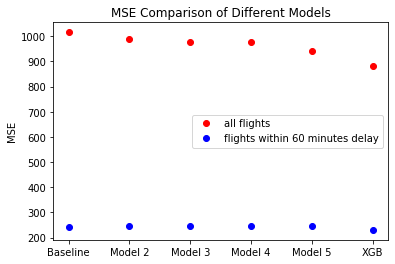

In [91]:
x_vals = ['Baseline', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'XGB']
y_vals = [1016.0188, 987.2611, 977.7327, 977.7327, 940.1131, 882.568]
y_vals_normal = [241.5599, 243.8135, 246.0632, 245.8958, 246.0451, 230.2034]
fig, ax = plt.subplots()
ax.plot(x_vals, y_vals, 'ro', label='all flights')
ax.plot(x_vals, y_vals_normal, 'bo', label='flights within 60 minutes delay')
ax.legend()
plt.ylabel('MSE')
plt.title('MSE Comparison of Different Models')
plt.show()

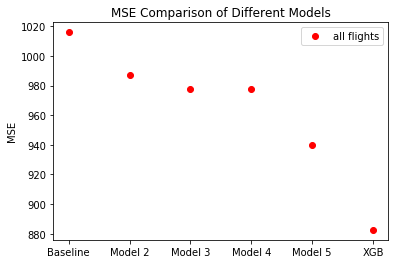

In [92]:
x_vals = ['Baseline', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'XGB']
y_vals = [1016.0188, 987.2611, 977.7327, 977.7327, 940.1131, 882.568]
y_vals_normal = [241.5599, 243.8135, 246.0632, 245.8958, 246.0451, 230.2034]
fig, ax = plt.subplots()
ax.plot(x_vals, y_vals, 'ro', label='all flights')
ax.legend()
plt.ylabel('MSE')
plt.title('MSE Comparison of Different Models')
plt.show()

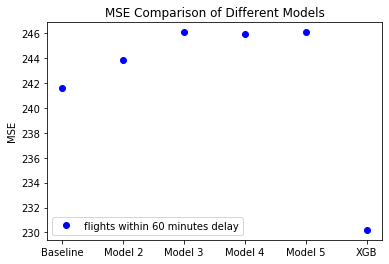

In [93]:
x_vals = ['Baseline', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'XGB']
y_vals = [1016.0188, 987.2611, 977.7327, 977.7327, 940.1131, 882.568]
y_vals_normal = [241.5599, 243.8135, 246.0632, 245.8958, 246.0451, 230.2034]
fig, ax = plt.subplots()
ax.plot(x_vals, y_vals_normal, 'bo', label='flights within 60 minutes delay')
ax.legend()
plt.ylabel('MSE')
plt.title('MSE Comparison of Different Models')
plt.show()